# Metric Learning

In this notebook, we will specifically be looking at Metric Learning. A complete blog post is available [here](http://amaarora.github.io/). 

With metric learning, the main idea is to increase the inter class discriminations and the intra class compactness. 

In [1]:
from pathlib import Path
import math
import pandas as pd 
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt
import torch
import albumentations
from torchvision import models
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F
from torchvision.models.utils import load_state_dict_from_url

In [2]:
DATA_PATH = Path('/home/ubuntu/.fastai/data/mnist_png/')
EPOCHS    = 5

## Extract labels and create train-val splits

In [3]:
img_paths = list(DATA_PATH.rglob('*.png'))
len(img_paths), img_paths[:2]

(70000,
 [PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9/48159.png'),
  PosixPath('/home/ubuntu/.fastai/data/mnist_png/training/9/1695.png')])

In [4]:
def extract_label(o):
     return o.parent.stem

In [5]:
df = pd.DataFrame({'img_paths': img_paths})
df['labels'] = df.img_paths.map(extract_label)
df.head()

,img_paths,labels
0,/home/ubuntu/.fastai/data/mnist_png/training/9...,9
1,/home/ubuntu/.fastai/data/mnist_png/training/9...,9
2,/home/ubuntu/.fastai/data/mnist_png/training/9...,9
3,/home/ubuntu/.fastai/data/mnist_png/training/9...,9
4,/home/ubuntu/.fastai/data/mnist_png/training/9...,9


In [6]:
def is_val(o):
    return 'training' not in str(o)

In [7]:
df['is_val'] = -1
df['is_val'] = df.img_paths.map(is_val)
df.head()

,img_paths,labels,is_val
0,/home/ubuntu/.fastai/data/mnist_png/training/9...,9,False
1,/home/ubuntu/.fastai/data/mnist_png/training/9...,9,False
2,/home/ubuntu/.fastai/data/mnist_png/training/9...,9,False
3,/home/ubuntu/.fastai/data/mnist_png/training/9...,9,False
4,/home/ubuntu/.fastai/data/mnist_png/training/9...,9,False


In [8]:
trn = df.query("is_val==False")
val = df.query("is_val==True")

len(trn), len(val)

(60000, 10000)

## Dataset

In [9]:
class MNIST_Dataset():
    def __init__(self, df, augmentations=None):
        self.df            = df
        self.img_paths     = df.img_paths.values
        self.labels        = df.labels.values
        self.augmentations = augmentations
        
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label    = self.labels[idx]        
        
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=img)
            img       = augmented['image']
        
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)    
        
        return {
            'image': torch.tensor(img, dtype=torch.float), 
            'label': torch.tensor(int(label), dtype=torch.long)
        }
    
    def __len__(self): 
        return len(self.df)

In [10]:
train_aug = albumentations.Compose([
    albumentations.Normalize()
])

val_aug = albumentations.Compose([
    albumentations.Normalize()

])

In [11]:
train_dataset = MNIST_Dataset(trn, augmentations=train_aug)
val_dataset   = MNIST_Dataset(val, augmentations=val_aug)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=False)

In [13]:
next(iter(train_dataloader))['image'].shape

torch.Size([64, 3, 28, 28])

## Model

In [14]:
class Resnet(nn.Module):
    def __init__(self, pretrained=True, arch_name='resnet34', n_out=10):
        super(Resnet, self).__init__()
        self.pretrained = pretrained
        self.base_model = getattr(models, arch_name)()
        nftrs           = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(nftrs, 2)
        self.fc         = nn.Linear(2, n_out)


    def forward(self, image, **kwargs):
        o1 = self.base_model(image)  
        o2 = self.fc(o1)
        return o1, o2

In [15]:
# project logits to 2 dim
model = Resnet()
model = model.to('cuda')

## Training

In [16]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
def train_one_epoch(train_loader, model, optimizer, loss_fn=nn.CrossEntropyLoss(), device='cuda'):
    losses = AverageMeter()
    model.train()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        data['image']  = data['image'].to(device)
        data['label']  = data['label'].to(device)
        
        optimizer.zero_grad()
        o1, o2 = model(**data)
        
        loss = loss_fn(o2, data['label'])

        with torch.set_grad_enabled(True):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg)
    return losses.avg

In [18]:
params = list(model.parameters()) #+list(model.base_model.parameters()) + 
optimizer = torch.optim.Adam(params, lr=1e-4)

In [19]:
def evaluate(valid_loader, model, device='cuda'):
    losses = AverageMeter()
    final_preds = []
    model.eval()
    preds_  = torch.zeros(1,2)
    labels_ = np.array([])
    with torch.no_grad():
        tk0 = tqdm(valid_loader, total=len(valid_loader))
        for data in tk0:
            for key, value in data.items():
                data[key] = value.to(device)
            o1, o2 = model(**data)
            preds_ = torch.cat([preds_, o1.cpu()])
            labels_ = np.append(labels_, data['label'].cpu().numpy())
            loss   = nn.CrossEntropyLoss()(o2, data['label'])
            preds  = o2.argmax(1)
            acc    = (preds == data['label']).float().mean()
            losses.update(acc.item(), valid_loader.batch_size) 
            preds = preds.cpu().numpy()
            final_preds.extend(preds)
            tk0.set_postfix(loss=losses.avg)
    return losses.avg, preds_[1:], labels_

### With Softmax Loss

In [20]:
# TRAINING using Tesla T4
for i in range(5):
    train_one_epoch(train_dataloader, model, optimizer)

100%|██████████| 938/938 [01:03<00:00, 14.75it/s, loss=0.104] 


In [21]:
loss, preds, labels = evaluate(val_dataloader, model)

100%|██████████| 157/157 [00:02<00:00, 62.75it/s, loss=0.983]


In [22]:
preds = pd.DataFrame(preds.numpy())
preds['label'] = labels
preds.head(2)

,0,1,label
0,38.511963,16.713697,9.0
1,64.323685,28.391975,9.0


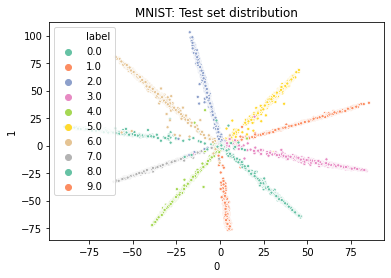

In [23]:
sns.scatterplot(data=preds, x=0, y=1, hue='label', palette='Set2', s=10);
plt.title("MNIST: Test set distribution");

### With Center Loss

In [24]:
# credits: https://github.com/KaiyangZhou/pytorch-center-loss/blob/master/center_loss.py

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [26]:
# TRAINING using Tesla T4
for i in range(3):
    train_one_epoch(train_dataloader, model, optimizer, loss_fn=CenterLoss(10,10,True))

100%|██████████| 938/938 [01:03<00:00, 14.67it/s, loss=8.35]


In [27]:
loss, preds, labels = evaluate(val_dataloader, model)

100%|██████████| 157/157 [00:02<00:00, 63.02it/s, loss=0.103]  


In [28]:
preds = pd.DataFrame(preds.numpy())
preds['label'] = labels
preds.head(2)

,0,1,label
0,0.203384,-0.598501,9.0
1,0.238211,-0.528210,9.0


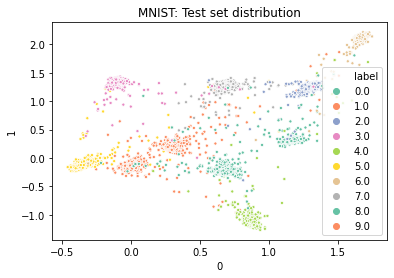

In [29]:
sns.scatterplot(data=preds, x=0, y=1, hue='label', palette='Set2', s=10);
plt.title("MNIST: Test set distribution");